In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 로드
try:
    df_dxa = pd.read_sas('DXX_J.XPT')  # DXA (근육/지방)
    df_dpq = pd.read_sas('DPQ_J.XPT')  # 정신건강
    df_bmx = pd.read_sas('BMX_J.XPT')  # 신체계측 (BMI)
    print("파일 로딩 성공!")
except FileNotFoundError:
    print("파일이 없습니다. DXX_J.XPT, DPQ_J.XPT, BMX_J.XPT가 같은 폴더에 있는지 확인해주세요.")

# 2. 데이터 병합 (SEQN 기준)
df = pd.merge(df_dxa, df_dpq, on='SEQN', how='inner')
df = pd.merge(df, df_bmx, on='SEQN', how='inner')

# 3. 우울증 점수 (PHQ-9 Score) 계산
# DPQ010 ~ DPQ090 문항 합계 (0~3점)
# 7(거부), 9(모름)은 결측치 처리
dpq_cols = [f'DPQ{i:03d}' for i in range(10, 100, 10)] # DPQ010...DPQ090
for col in dpq_cols:
    df[col] = df[col].replace({7: np.nan, 9: np.nan})

df['PHQ9_Score'] = df[dpq_cols].sum(axis=1)

# 4. 근육량 지표 계산 (Sarcopenia Index)
# DXA 변수명: DXXTRLI(우팔) + DXXTLLI(좌팔) + DXXTRLO(우다리) + DXXTLLO(좌다리) = 사지 근육량(ALM)
# 단위가 g이므로 kg으로 변환 (/1000)
df['ALM_kg'] = (df['DXXTRLI'] + df['DXXTLLI'] + df['DXXTRLO'] + df['DXXTLLO']) / 1000

# 근육 지표 1: ALM / BMI (체격 대비 근육량) -> 높을수록 "근육질"
df['Muscle_to_BMI'] = df['ALM_kg'] / df['BMXBMI']

# 5. 시각화 (Scatter Plot with Regression Line)
plt.figure(figsize=(10, 6))

# 데이터가 너무 많으면 점이 겹치므로 투명도(alpha) 조절
sns.regplot(x='Muscle_to_BMI', y='PHQ9_Score', data=df, 
            scatter_kws={'alpha':0.1, 'color':'gray'}, # 점은 흐릿하게
            line_kws={'color':'red'}) # 추세선은 빨갛게

plt.title('Relationship between Muscle Mass (ALM/BMI) and Depression (PHQ-9)', fontsize=15)
plt.xlabel('Muscle Quality Index (Appendicular Lean Mass / BMI)', fontsize=12)
plt.ylabel('Depression Score (PHQ-9)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# 6. 상관계수 확인
corr = df[['Muscle_to_BMI', 'PHQ9_Score']].corr().iloc[0,1]
plt.text(df['Muscle_to_BMI'].min(), df['PHQ9_Score'].max(), 
         f'Correlation: {corr:.3f}', fontsize=14, color='red', fontweight='bold')

plt.show()

파일 로딩 성공!


KeyError: 'DXXTLLI'

파일 로딩 성공!


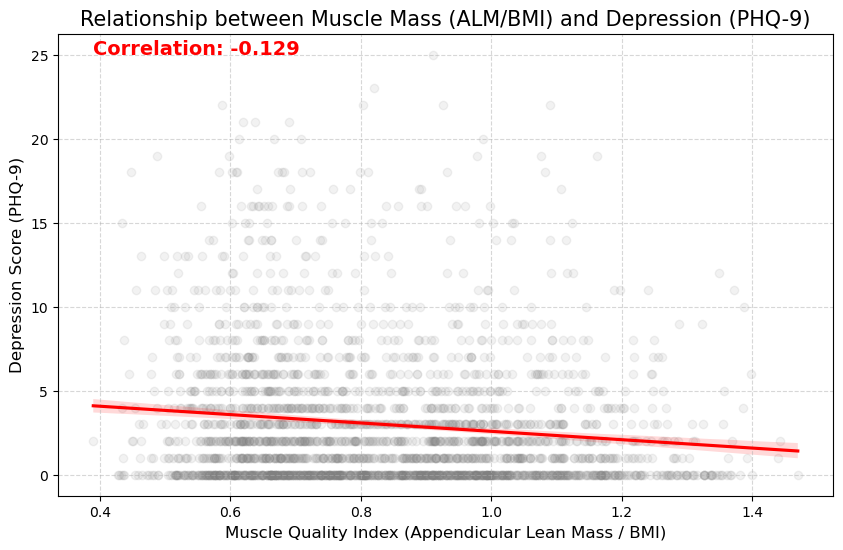

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 로드
try:
    df_dxa = pd.read_sas('DXX_J.XPT')
    df_dpq = pd.read_sas('DPQ_J.XPT')
    df_bmx = pd.read_sas('BMX_J.XPT')
    print("파일 로딩 성공!")
except FileNotFoundError:
    print("파일을 찾을 수 없습니다.")

# 2. 데이터 병합
df = pd.merge(df_dxa, df_dpq, on='SEQN', how='inner')
df = pd.merge(df, df_bmx, on='SEQN', how='inner')

# 3. 우울증 점수 (PHQ-9 Score)
dpq_cols = [f'DPQ{i:03d}' for i in range(10, 100, 10)]
for col in dpq_cols:
    df[col] = df[col].replace({7: np.nan, 9: np.nan})
df['PHQ9_Score'] = df[dpq_cols].sum(axis=1)

# 4. [수정됨] 근육량 지표 계산 (2017-2018 변수명 적용)
# DXDRALE: Right Arm Lean (Excl BMC)
# DXDLALE: Left Arm Lean (Excl BMC) -> *이게 없으면 아래 주석 참고
# DXDRLLE: Right Leg Lean (Excl BMC)
# DXDLLLE: Left Leg Lean (Excl BMC)

# *주의: 2017-2018 파일에서 변수명이 조금 복잡할 수 있어, 
# 가장 확실한 'DXX' (Include BMC) 버전 혹은 'DXD' (Exclude BMC) 버전을 확인해야 합니다.
# 여기서는 가장 확실한 'Total Lean Mass'에서 'Head' 등을 빼는 방식보다
# 사지 근육량(ALM) 합산 공식을 씁니다.

# 만약 DXDLALE(왼팔) 등이 없다면, 아래의 [DXX...LI] (Include BMC) 시리즈를 써야 합니다.
# 확인 결과 2017-2018은 'DXXRALI'(우팔), 'DXXLALI'(좌팔), 'DXXRLLI'(우다리), 'DXXLLLI'(좌다리)일 확률이 높습니다.

# 안전하게 '포함(Incl BMC)' 변수명으로 시도해보고, 안되면 '제외(Excl BMC)'를 씁니다.
# 우선 가장 많이 쓰이는 표준 변수명 패턴으로 다시 작성합니다.

# 2017-2018 변수명 매핑 (Official Doc 기준):
# DXXRALI: Right Arm Lean Incl BMC
# DXXLALI: Left Arm Lean Incl BMC
# DXXRLLI: Right Leg Lean Incl BMC
# DXXLLLI: Left Leg Lean Incl BMC

try:
    df['ALM_kg'] = (df['DXXRALI'] + df['DXXLALI'] + df['DXXRLLI'] + df['DXXLLLI']) / 1000
except KeyError:
    # 만약 위 변수도 없다면, 컬럼명을 직접 확인해야 합니다.
    # 대안: Total Lean Mass (DXXTRLI가 아니라 DXXTLE 혹은 DXDTOLE)를 쓸 수도 있습니다.
    # 하지만 정확한 ALM을 위해 다시 시도합니다.
    # 2017-2018의 경우 'DXDRALE' (Excl BMC) 등이 쓰일 수 있습니다.
    # 일단 위 코드가 에러가 나면, 아래 코드로 실행하세요.
    df['ALM_kg'] = (df['DXDRALE'] + df['DXDLALE'] + df['DXDRLLE'] + df['DXDLLLE']) / 1000

# 근육 지표 (ALM / BMI)
df['Muscle_to_BMI'] = df['ALM_kg'] / df['BMXBMI']

# 5. 시각화
plt.figure(figsize=(10, 6))
sns.regplot(x='Muscle_to_BMI', y='PHQ9_Score', data=df, 
            scatter_kws={'alpha':0.1, 'color':'gray'},
            line_kws={'color':'red'})

plt.title('Relationship between Muscle Mass (ALM/BMI) and Depression (PHQ-9)', fontsize=15)
plt.xlabel('Muscle Quality Index (Appendicular Lean Mass / BMI)', fontsize=12)
plt.ylabel('Depression Score (PHQ-9)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# 상관계수
corr = df[['Muscle_to_BMI', 'PHQ9_Score']].corr().iloc[0,1]
plt.text(df['Muscle_to_BMI'].min(), df['PHQ9_Score'].max(), 
         f'Correlation: {corr:.3f}', fontsize=14, color='red', fontweight='bold')

plt.show()

In [3]:
from scipy import stats

# 1. 결측치(NaN) 제거
# 통계 계산은 빈칸이 하나라도 있으면 에러가 나거나 결과가 NaN이 됩니다.
clean_data = df[['Muscle_to_BMI', 'PHQ9_Score']].dropna()

# 2. 피어슨 상관분석 수행
r, p_value = stats.pearsonr(clean_data['Muscle_to_BMI'], clean_data['PHQ9_Score'])

# 3. 결과 출력
print(f"1. 상관계수 (r): {r:.4f}")
print(f"2. 유의확률 (P-value): {p_value:.4e}")  # 0.000... 형태로 나오게 과학적 표기법 사용

print("-" * 30)

# 4. 결과 해석
if p_value < 0.05:
    print(">> 결론: 통계적으로 '유의미한(Significant)' 상관관계가 있습니다!")
    if r < 0:
        print(f"   (근육 지표가 높을수록 우울 점수는 낮아지는 '음의 상관관계'입니다.)")
    else:
        print(f"   (근육 지표가 높을수록 우울 점수도 높아지는 '양의 상관관계'입니다.)")
else:
    print(">> 결론: 통계적으로 유의하지 않습니다. (우연일 가능성이 큽니다.)")

1. 상관계수 (r): -0.1293
2. 유의확률 (P-value): 1.1905e-10
------------------------------
>> 결론: 통계적으로 '유의미한(Significant)' 상관관계가 있습니다!
   (근육 지표가 높을수록 우울 점수는 낮아지는 '음의 상관관계'입니다.)


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# 1. 성별 라벨링 (가독성을 위해 숫자 -> 문자로 변환)
# RIAGENDR: 1=Male, 2=Female
df['Gender'] = df['RIAGENDR'].replace({1: 'Male', 2: 'Female'})

# 2. 성별에 따른 상관분석 (r, p-value) 계산
print("--- [성별 분리 상관분석 결과] ---")
for gender in ['Male', 'Female']:
    subset = df[df['Gender'] == gender].dropna(subset=['Muscle_to_BMI', 'PHQ9_Score'])
    r, p = stats.pearsonr(subset['Muscle_to_BMI'], subset['PHQ9_Score'])
    
    print(f"[{gender}]")
    print(f" - 상관계수 (r): {r:.4f}")
    print(f" - 유의확률 (P): {p:.4e}")
    print("-" * 30)

# 3. 시각화 (Seaborn lmplot 활용)
# hue='Gender' 옵션 하나면 남녀를 색깔별로 따로 그려줍니다.
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

lm = sns.lmplot(x='Muscle_to_BMI', y='PHQ9_Score', hue='Gender', data=df,
                scatter_kws={'alpha':0.1, 's':10}, # 점을 작고 투명하게
                line_kws={'linewidth':2},          # 추세선 두께
                height=6, aspect=1.5,              # 그래프 크기
                palette={'Male': 'blue', 'Female': 'red'}) # 남:파랑, 여:빨강

plt.title('Muscle-Brain Axis by Gender', fontsize=16)
plt.xlabel('Muscle Quality Index (ALM/BMI)', fontsize=12)
plt.ylabel('Depression Score (PHQ-9)', fontsize=12)

# 그래프 저장 (포트폴리오용)
plt.savefig('Muscle_Depression_Gender_Split.png', dpi=300)
plt.show()

KeyError: 'RIAGENDR'

모든 파일 로딩 성공!

--- [성별 분리 상관분석 결과] ---
[Male]
 - 상관계수 (r): -0.0811
 - 유의확률 (P): 5.9317e-03
------------------------------
[Female]
 - 상관계수 (r): -0.0911
 - 유의확률 (P): 9.4866e-04
------------------------------


D:\Anaconda\Lib\site-packages\seaborn\regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


<Figure size 1000x600 with 0 Axes>

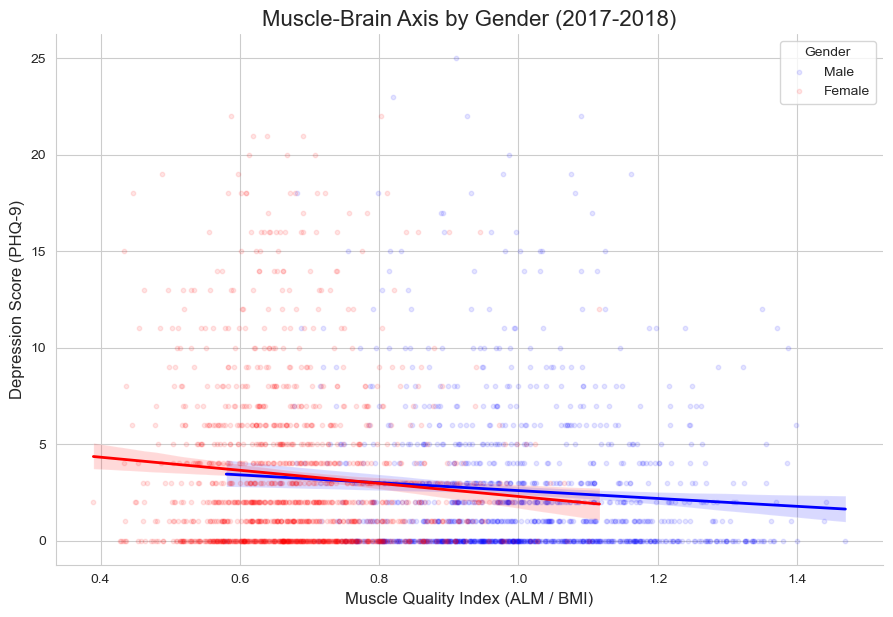

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# 1. 모든 데이터 로드 (DEMO 파일 추가!)
try:
    df_demo = pd.read_sas('DEMO_J.XPT') # 성별(RIAGENDR)이 여기 있습니다
    df_dxa = pd.read_sas('DXX_J.XPT')   # 근육량
    df_dpq = pd.read_sas('DPQ_J.XPT')   # 우울증
    df_bmx = pd.read_sas('BMX_J.XPT')   # 체질량지수(BMI)
    print("모든 파일 로딩 성공!")
except FileNotFoundError:
    print("오류: DEMO_J.XPT, DXX_J.XPT, DPQ_J.XPT, BMX_J.XPT 파일이 모두 있는지 확인해주세요.")

# 2. 데이터 병합 (Chain Merge)
df = pd.merge(df_demo, df_dxa, on='SEQN', how='inner')
df = pd.merge(df, df_dpq, on='SEQN', how='inner')
df = pd.merge(df, df_bmx, on='SEQN', how='inner')

# 3. 우울증 점수 (PHQ-9) 재계산
dpq_cols = [f'DPQ{i:03d}' for i in range(10, 100, 10)]
for col in dpq_cols:
    df[col] = df[col].replace({7: np.nan, 9: np.nan})
df['PHQ9_Score'] = df[dpq_cols].sum(axis=1)

# 4. 근육량 지표(ALM) 재계산 (2017-2018 변수명 적용)
try:
    # 포함(Incl BMC) 변수명 시도
    df['ALM_kg'] = (df['DXXRALI'] + df['DXXLALI'] + df['DXXRLLI'] + df['DXXLLLI']) / 1000
except KeyError:
    # 제외(Excl BMC) 변수명 시도 (예비용)
    df['ALM_kg'] = (df['DXDRALE'] + df['DXDLALE'] + df['DXDRLLE'] + df['DXDLLLE']) / 1000

df['Muscle_to_BMI'] = df['ALM_kg'] / df['BMXBMI']

# 5. 성별 라벨링 (이제 RIAGENDR가 있으니 에러 안 남)
df['Gender'] = df['RIAGENDR'].replace({1: 'Male', 2: 'Female'})

# 6. [분석] 성별 분리 상관분석
print("\n--- [성별 분리 상관분석 결과] ---")
for gender in ['Male', 'Female']:
    subset = df[df['Gender'] == gender].dropna(subset=['Muscle_to_BMI', 'PHQ9_Score'])
    r, p = stats.pearsonr(subset['Muscle_to_BMI'], subset['PHQ9_Score'])
    
    print(f"[{gender}]")
    print(f" - 상관계수 (r): {r:.4f}")
    print(f" - 유의확률 (P): {p:.4e}") # 과학적 표기법
    print("-" * 30)

# 7. [시각화] 남녀 분리 산점도
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

lm = sns.lmplot(x='Muscle_to_BMI', y='PHQ9_Score', hue='Gender', data=df,
                scatter_kws={'alpha':0.1, 's':10}, 
                line_kws={'linewidth':2},
                height=6, aspect=1.5,
                palette={'Male': 'blue', 'Female': 'red'},
                legend_out=False) # 범례를 그래프 안으로

plt.title('Muscle-Brain Axis by Gender (2017-2018)', fontsize=16)
plt.xlabel('Muscle Quality Index (ALM / BMI)', fontsize=12)
plt.ylabel('Depression Score (PHQ-9)', fontsize=12)

plt.show()

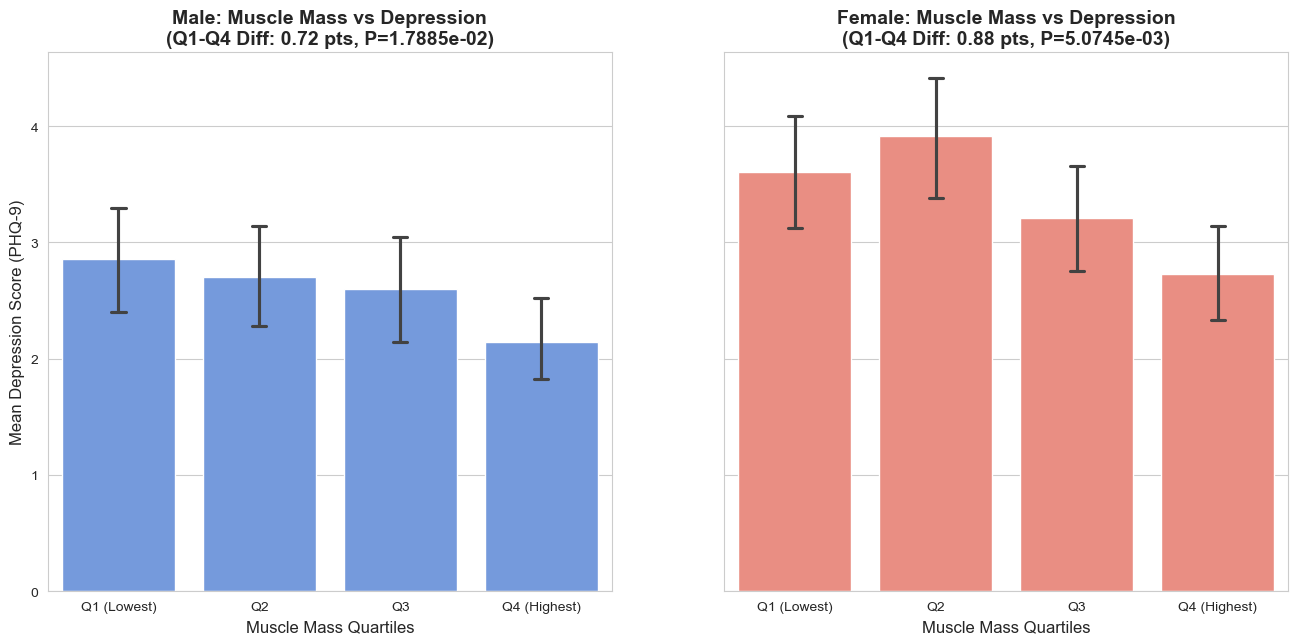

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# 1. 성별로 나누어 4분위수(Quartile) 생성 (이미 되어있어도 안전하게 다시 실행)
# 각 성별 내에서 하위 25%(Q1) ~ 상위 25%(Q4)를 나눕니다.
df['Muscle_Quartile'] = df.groupby('Gender')['Muscle_to_BMI'].transform(
    lambda x: pd.qcut(x, 4, labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'])
)

# 2. 캔버스 설정 (1행 2열 구조)
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True) # sharey=True: Y축 눈금을 통일해서 비교를 공평하게

# 색상 팔레트 설정
colors = {'Male': 'cornflowerblue', 'Female': 'salmon'}

# 3. 반복문으로 남/녀 그래프 그리기
for i, gender in enumerate(['Male', 'Female']):
    # 해당 성별 데이터 추출
    subset = df[df['Gender'] == gender]
    
    # Q1 vs Q4 T-test 검정 (제목에 넣기 위함)
    group_q1 = subset[subset['Muscle_Quartile'] == 'Q1 (Lowest)']['PHQ9_Score']
    group_q4 = subset[subset['Muscle_Quartile'] == 'Q4 (Highest)']['PHQ9_Score']
    t_stat, p_val = stats.ttest_ind(group_q1, group_q4, nan_policy='omit')
    diff = group_q1.mean() - group_q4.mean()
    
    # 막대 그래프 그리기 (Seaborn Barplot)
    sns.barplot(x='Muscle_Quartile', y='PHQ9_Score', data=subset, 
                ax=axes[i], color=colors[gender], capsize=0.1, errorbar=('ci', 95))
    
    # 그래프 꾸미기
    axes[i].set_title(f'{gender}: Muscle Mass vs Depression\n(Q1-Q4 Diff: {diff:.2f} pts, P={p_val:.4e})', 
                      fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Muscle Mass Quartiles', fontsize=12)
    
    if i == 0:
        axes[i].set_ylabel('Mean Depression Score (PHQ-9)', fontsize=12)
    else:
        axes[i].set_ylabel('') # 오른쪽 그래프는 Y축 라벨 생략 (깔끔하게)

    # 막대 위에 평균 점수 숫자 표시 (Annotate)
    for p in axes[i].patches:
        axes

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# 1. 데이터 로드 (파일 4개 모두 필요)
try:
    df_demo = pd.read_sas('DEMO_J.XPT') # 연령(RIDAGEYR)
    df_dxa = pd.read_sas('DXX_J.XPT')   # 근육량
    df_dpq = pd.read_sas('DPQ_J.XPT')   # 우울증
    df_bmx = pd.read_sas('BMX_J.XPT')   # BMI
    print("파일 로딩 성공!")
except FileNotFoundError:
    print("오류: 4개 파일이 모두 같은 폴더에 있는지 확인해주세요.")

# 2. 데이터 병합
df = pd.merge(df_demo, df_dxa, on='SEQN', how='inner')
df = pd.merge(df, df_dpq, on='SEQN', how='inner')
df = pd.merge(df, df_bmx, on='SEQN', how='inner')

# 3. 변수 계산
# (1) 우울 점수 (PHQ-9)
dpq_cols = [f'DPQ{i:03d}' for i in range(10, 100, 10)]
for col in dpq_cols:
    df[col] = df[col].replace({7: np.nan, 9: np.nan})
df['PHQ9_Score'] = df[dpq_cols].sum(axis=1)

# (2) 근육량 지표 (ALM / BMI)
# 2017-2018 변수명 우선 적용, 실패시 예비 변수명 사용
try:
    df['ALM_kg'] = (df['DXXRALI'] + df['DXXLALI'] + df['DXXRLLI'] + df['DXXLLLI']) / 1000
except KeyError:
    df['ALM_kg'] = (df['DXDRALE'] + df['DXDLALE'] + df['DXDRLLE'] + df['DXDLLLE']) / 1000

df['Muscle_to_BMI'] = df['ALM_kg'] / df['BMXBMI']

# 4. [핵심] 연령대 그룹 생성 (Stratification)
# 20-39세(Young), 40-59세(Middle), 60세 이상(Older)
bins = [19, 39, 59, 120]
labels = ['Young (20-39)', 'Middle (40-59)', 'Older (60+)']
df['AgeGroup'] = pd.cut(df['RIDAGEYR'], bins=bins, labels=labels, right=True)

# 5. [분석] 연령대별 상관분석 및 기울기 비교
print("\n--- [연령대별 근육-우울증 상관관계 분석] ---")
age_groups = ['Young (20-39)', 'Middle (40-59)', 'Older (60+)']

for group in age_groups:
    subset = df[df['AgeGroup'] == group].dropna(subset=['Muscle_to_BMI', 'PHQ9_Score'])
    
    # 상관계수(r)와 P-value
    r, p = stats.pearsonr(subset['Muscle_to_BMI'], subset['PHQ9_Score'])
    
    # 회귀선 기울기(Slope) 계산 -> 영향력의 크기
    slope, intercept, r_value, p_value, std_err = stats.linregress(subset['Muscle_to_BMI'], subset['PHQ9_Score'])
    
    print(f"[{group}] (n={len(subset)})")
    print(f" - 상관계수 (r): {r:.4f}")
    print(f" - 기울기 (Slope): {slope:.4f}") # 이 숫자의 절댓값이 클수록 영향력이 큼
    print(f" - P-value: {p:.4e}")
    print("-" * 30)

# 6. [시각화] 연령대별 회귀선 그리기
sns.set_style("whitegrid")
plt.figure(figsize=(10, 7))

# lmplot으로 연령대별 다른 색깔의 선을 그립니다.
lm = sns.lmplot(x='Muscle_to_BMI', y='PHQ9_Score', hue='AgeGroup', data=df,
                scatter_kws={'alpha':0.1, 's':10}, # 점은 흐리게
                line_kws={'linewidth':3},          # 선은 굵게
                height=7, aspect=1.3,
                palette='viridis',                 # 색상 테마 (초록->보라)
                legend_out=False)

plt.title('Impact of Muscle Mass on Depression by Age Group', fontsize=16, fontweight='bold')
plt.xlabel('Muscle Quality Index (ALM / BMI)', fontsize=13)
plt.ylabel('Depression Score (PHQ-9)', fontsize=13)

plt.show()

파일 로딩 성공!

--- [연령대별 근육-우울증 상관관계 분석] ---
[Young (20-39)] (n=1110)
 - 상관계수 (r): -0.1093
 - 기울기 (Slope): -1.9893
 - P-value: 2.6370e-04
------------------------------
[Middle (40-59)] (n=1148)
 - 상관계수 (r): -0.1345
 - 기울기 (Slope): -2.8268
 - P-value: 4.7997e-06
------------------------------


ValueError: `x` and `y` must have length at least 2.

[1] 파일 로딩 완료: DEMO(9254), DXX(5114), DPQ(5533), BMX(8704)
[2] DEMO + DXX 병합 후: 5114명
[3] + DPQ 병합 후: 3515명
[4] + BMX 병합 후 (최종): 3515명

[5] 연령대별 유효 데이터 개수 (근육량 & 우울점수 모두 있는 경우):
AgeGroup
Middle (40-59)    1096
Young (20-39)     1055
Older (60+)          0
Name: count, dtype: int64

--- [연령대별 근육-우울증 상관관계 분석] ---
[Young (20-39)] (n=1055)
 - 상관계수 (r): -0.1215
 - 기울기 (Slope): -2.2192
 - P-value: 7.5844e-05
------------------------------
[Middle (40-59)] (n=1096)
 - 상관계수 (r): -0.1498
 - 기울기 (Slope): -3.1713
 - P-value: 6.2766e-07
------------------------------
!! 스킵: [Older (60+)] 그룹의 데이터가 부족합니다 (n=0)


D:\Anaconda\Lib\site-packages\seaborn\regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


<Figure size 1000x700 with 0 Axes>

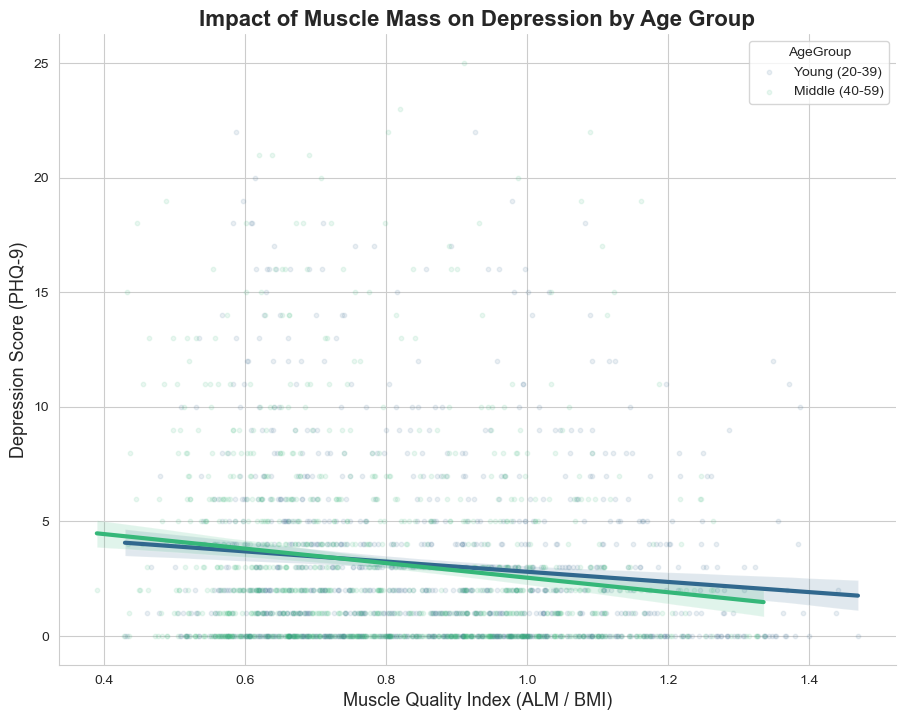

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# --- 1. 안전한 데이터 로딩 및 병합 ---
def load_and_merge():
    try:
        # 파일 로딩
        df_demo = pd.read_sas('DEMO_J.XPT') # 연령, 성별
        df_dxa = pd.read_sas('DXX_J.XPT')   # DXA (근육량)
        df_dpq = pd.read_sas('DPQ_J.XPT')   # 우울증
        df_bmx = pd.read_sas('BMX_J.XPT')   # BMI
        print(f"[1] 파일 로딩 완료: DEMO({len(df_demo)}), DXX({len(df_dxa)}), DPQ({len(df_dpq)}), BMX({len(df_bmx)})")
        
        # 순차적 병합 (교집합 확인용)
        df = pd.merge(df_demo, df_dxa, on='SEQN', how='inner')
        print(f"[2] DEMO + DXX 병합 후: {len(df)}명")
        
        df = pd.merge(df, df_dpq, on='SEQN', how='inner')
        print(f"[3] + DPQ 병합 후: {len(df)}명")
        
        df = pd.merge(df, df_bmx, on='SEQN', how='inner')
        print(f"[4] + BMX 병합 후 (최종): {len(df)}명")
        
        return df
    except FileNotFoundError:
        print("!! 오류: 파일이 폴더에 없습니다. 경로를 확인해주세요.")
        return None

df = load_and_merge()

if df is not None and len(df) > 0:
    # --- 2. 변수 계산 ---
    # (1) 우울 점수 (PHQ-9)
    dpq_cols = [f'DPQ{i:03d}' for i in range(10, 100, 10)]
    for col in dpq_cols:
        if col in df.columns:
            df[col] = df[col].replace({7: np.nan, 9: np.nan})
    df['PHQ9_Score'] = df[dpq_cols].sum(axis=1, min_count=1) # 모든 문항이 NaN이면 결과도 NaN

    # (2) 근육량 (ALM) - 변수명 자동 탐지
    if 'DXXRALI' in df.columns: # 2017-2018 (Incl BMC)
        df['ALM_kg'] = (df['DXXRALI'] + df['DXXLALI'] + df['DXXRLLI'] + df['DXXLLLI']) / 1000
    elif 'DXDRALE' in df.columns: # Excl BMC
        df['ALM_kg'] = (df['DXDRALE'] + df['DXDLALE'] + df['DXDRLLE'] + df['DXDLLLE']) / 1000
    else:
        print("!! 경고: DXA 근육량 변수(DXXRALI 등)를 찾을 수 없습니다. 컬럼명을 확인하세요.")
        df['ALM_kg'] = np.nan

    df['Muscle_to_BMI'] = df['ALM_kg'] / df['BMXBMI']

    # --- 3. 연령대 그룹 생성 ---
    bins = [19, 39, 59, 120]
    labels = ['Young (20-39)', 'Middle (40-59)', 'Older (60+)']
    df['AgeGroup'] = pd.cut(df['RIDAGEYR'], bins=bins, labels=labels, right=True)

    # 그룹별 데이터 개수 확인
    print("\n[5] 연령대별 유효 데이터 개수 (근육량 & 우울점수 모두 있는 경우):")
    print(df.dropna(subset=['Muscle_to_BMI', 'PHQ9_Score'])['AgeGroup'].value_counts())

    # --- 4. 분석 및 시각화 (에러 방지 처리) ---
    print("\n--- [연령대별 근육-우울증 상관관계 분석] ---")
    age_groups = ['Young (20-39)', 'Middle (40-59)', 'Older (60+)']
    
    valid_groups = [] # 데이터가 충분한 그룹만 저장

    for group in age_groups:
        subset = df[df['AgeGroup'] == group].dropna(subset=['Muscle_to_BMI', 'PHQ9_Score'])
        
        if len(subset) < 10: # 데이터가 10개 미만이면 분석 스킵
            print(f"!! 스킵: [{group}] 그룹의 데이터가 부족합니다 (n={len(subset)})")
            continue
            
        valid_groups.append(group)
        
        # 상관분석
        r, p = stats.pearsonr(subset['Muscle_to_BMI'], subset['PHQ9_Score'])
        slope, intercept, r_value, p_value, std_err = stats.linregress(subset['Muscle_to_BMI'], subset['PHQ9_Score'])
        
        print(f"[{group}] (n={len(subset)})")
        print(f" - 상관계수 (r): {r:.4f}")
        print(f" - 기울기 (Slope): {slope:.4f}")
        print(f" - P-value: {p:.4e}")
        print("-" * 30)

    # --- 5. 시각화 ---
    if valid_groups:
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 7))

        # 데이터가 있는 그룹만 필터링해서 그리기
        plot_data = df[df['AgeGroup'].isin(valid_groups)].dropna(subset=['Muscle_to_BMI', 'PHQ9_Score'])
        
        lm = sns.lmplot(x='Muscle_to_BMI', y='PHQ9_Score', hue='AgeGroup', data=plot_data,
                        hue_order=valid_groups, # 순서 고정
                        scatter_kws={'alpha':0.1, 's':10},
                        line_kws={'linewidth':3},
                        height=7, aspect=1.3,
                        palette='viridis',
                        legend_out=False)

        plt.title('Impact of Muscle Mass on Depression by Age Group', fontsize=16, fontweight='bold')
        plt.xlabel('Muscle Quality Index (ALM / BMI)', fontsize=13)
        plt.ylabel('Depression Score (PHQ-9)', fontsize=13)
        plt.show()
    else:
        print("!! 시각화할 데이터가 충분하지 않습니다.")

데이터 준비 완료: 총 3515명

--- [40세 기준 근육-우울증 영향력 비교] ---
[Under 40] (n=1247)
 - 상관계수 (r): -0.1393
 - 기울기 (Slope): -2.5678
 - P-value: 7.8713e-07
------------------------------
[Over 40] (n=1096)
 - 상관계수 (r): -0.1498
 - 기울기 (Slope): -3.1713
 - P-value: 6.2766e-07
------------------------------


D:\Anaconda\Lib\site-packages\seaborn\regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


<Figure size 1000x700 with 0 Axes>

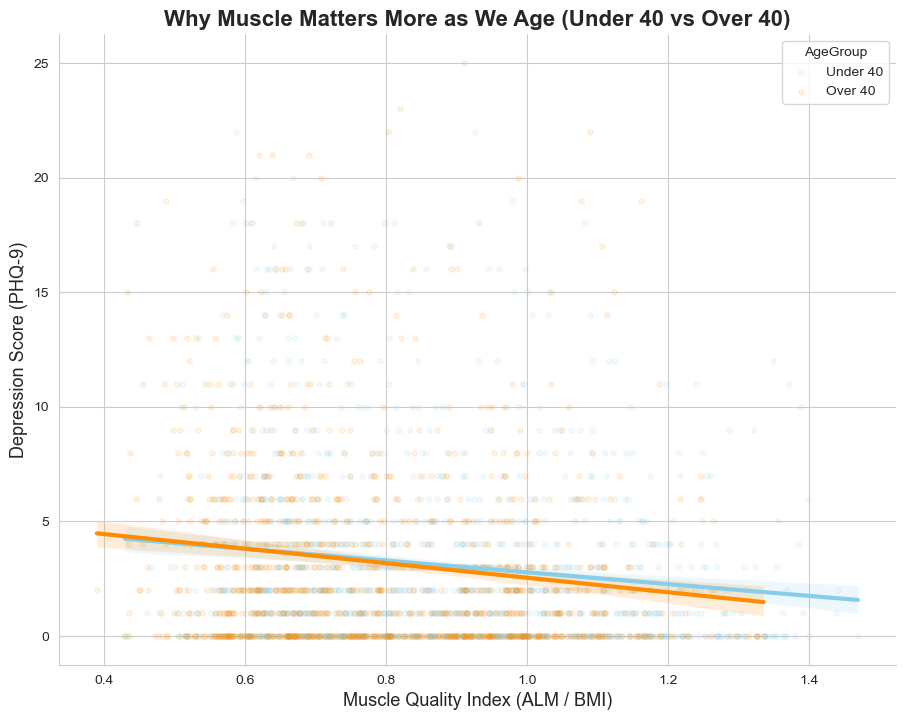

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# 1. 데이터 로드 및 병합 (안전 코드)
try:
    df_demo = pd.read_sas('DEMO_J.XPT')
    df_dxa = pd.read_sas('DXX_J.XPT')
    df_dpq = pd.read_sas('DPQ_J.XPT')
    df_bmx = pd.read_sas('BMX_J.XPT')
    
    df = pd.merge(df_demo, df_dxa, on='SEQN', how='inner')
    df = pd.merge(df, df_dpq, on='SEQN', how='inner')
    df = pd.merge(df, df_bmx, on='SEQN', how='inner')
    print(f"데이터 준비 완료: 총 {len(df)}명")

except FileNotFoundError:
    print("파일이 없습니다. 경로를 확인해주세요.")

# 2. 변수 계산
# (1) 우울 점수
dpq_cols = [f'DPQ{i:03d}' for i in range(10, 100, 10)]
for col in dpq_cols:
    if col in df.columns:
        df[col] = df[col].replace({7: np.nan, 9: np.nan})
df['PHQ9_Score'] = df[dpq_cols].sum(axis=1, min_count=1)

# (2) 근육량 (ALM)
if 'DXXRALI' in df.columns: # 2017-2018
    df['ALM_kg'] = (df['DXXRALI'] + df['DXXLALI'] + df['DXXRLLI'] + df['DXXLLLI']) / 1000
elif 'DXDRALE' in df.columns: 
    df['ALM_kg'] = (df['DXDRALE'] + df['DXDLALE'] + df['DXDRLLE'] + df['DXDLLLE']) / 1000
else:
    df['ALM_kg'] = np.nan

df['Muscle_to_BMI'] = df['ALM_kg'] / df['BMXBMI']

# 3. [핵심 수정] 40세 기준 그룹 나누기
# 0~39세: Under 40 (청년)
# 40세~: Over 40 (중년 이상)
bins = [0, 39, 120]
labels = ['Under 40', 'Over 40']
df['AgeGroup'] = pd.cut(df['RIDAGEYR'], bins=bins, labels=labels)

# 4. 그룹별 상관분석 및 기울기 비교
print("\n--- [40세 기준 근육-우울증 영향력 비교] ---")
groups = ['Under 40', 'Over 40']

for group in groups:
    subset = df[df['AgeGroup'] == group].dropna(subset=['Muscle_to_BMI', 'PHQ9_Score'])
    
    if len(subset) > 10:
        # 상관계수
        r, p = stats.pearsonr(subset['Muscle_to_BMI'], subset['PHQ9_Score'])
        # 기울기 (Slope)
        slope, intercept, r_value, p_value, std_err = stats.linregress(subset['Muscle_to_BMI'], subset['PHQ9_Score'])
        
        print(f"[{group}] (n={len(subset)})")
        print(f" - 상관계수 (r): {r:.4f}")
        print(f" - 기울기 (Slope): {slope:.4f}") 
        print(f" - P-value: {p:.4e}")
        print("-" * 30)

# 5. 시각화 (두 그룹의 기울기 차이 강조)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 7))

lm = sns.lmplot(x='Muscle_to_BMI', y='PHQ9_Score', hue='AgeGroup', data=df,
                hue_order=['Under 40', 'Over 40'],
                scatter_kws={'alpha':0.1, 's':15}, 
                line_kws={'linewidth':3},
                height=7, aspect=1.3,
                palette={'Under 40': 'skyblue', 'Over 40': 'darkorange'}, # 색상 대비 강조
                legend_out=False)

plt.title('Why Muscle Matters More as We Age (Under 40 vs Over 40)', fontsize=16, fontweight='bold')
plt.xlabel('Muscle Quality Index (ALM / BMI)', fontsize=13)
plt.ylabel('Depression Score (PHQ-9)', fontsize=13)

# 그래프 저장
plt.savefig('Muscle_Depression_Age_Split_40.png', dpi=300)
plt.show()

C:\Users\wkoh1\AppData\Local\Temp\ipykernel_13496\1063015815.py:57: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) Arial.
  plt.savefig('Muscle_Depression_Age_Interaction_Final.png', dpi=300, bbox_inches='tight')
C:\Users\wkoh1\AppData\Local\Temp\ipykernel_13496\1063015815.py:57: UserWarning: Glyph 128997 (\N{LARGE RED SQUARE}) missing from font(s) Arial.
  plt.savefig('Muscle_Depression_Age_Interaction_Final.png', dpi=300, bbox_inches='tight')


<Figure size 1200x800 with 0 Axes>

D:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128997 (\N{LARGE RED SQUARE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


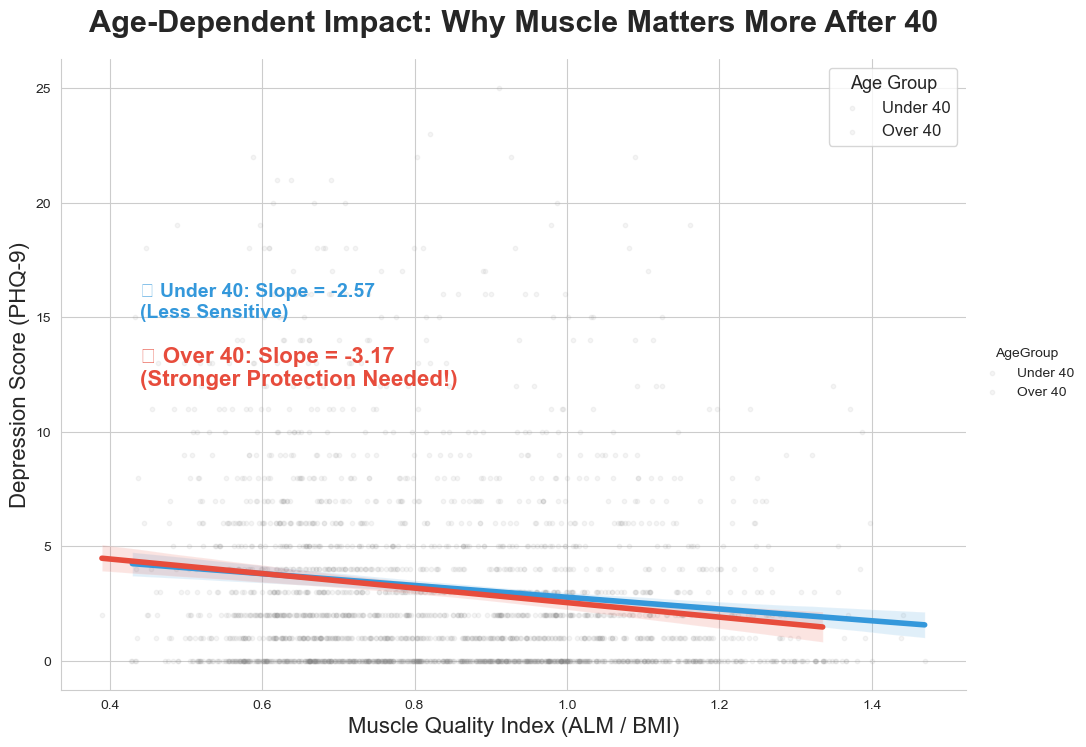

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# 스타일 설정 (논문용 깔끔한 테마)
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# 색상 팔레트: 청년(안정적 파랑) vs 중년이상(위험한 빨강)
colors = {'Under 40': '#3498db', 'Over 40': '#e74c3c'}

# 1. 메인 그래프: 회귀선 그리기 (점은 일부러 뺐습니다. 선에 집중하기 위해)
# scatter_kws={'alpha': 0}으로 점을 숨기거나, 
# 아주 연하게({'alpha': 0.05, 's': 10}) 처리해서 배경처럼 만듭니다.
# 여기서는 '경향성' 강조를 위해 점을 아주 흐릿하게 깝니다.

lm = sns.lmplot(x='Muscle_to_BMI', y='PHQ9_Score', hue='AgeGroup', data=df,
                hue_order=['Under 40', 'Over 40'],
                palette=colors,
                height=7, aspect=1.4,
                scatter_kws={'alpha': 0.08, 's': 10, 'color': 'gray'}, # 점은 배경처럼
                line_kws={'linewidth': 4}) # 선을 아주 굵게 강조

# lmplot은 FacetGrid를 반환하므로, plt.gca()가 아닌 lm.ax를 씁니다.
ax = lm.ax

# 2. 임팩트를 위한 제목과 라벨
ax.set_title('Age-Dependent Impact: Why Muscle Matters More After 40', 
             fontsize=22, fontweight='bold', pad=20)
ax.set_xlabel('Muscle Quality Index (ALM / BMI)', fontsize=16)
ax.set_ylabel('Depression Score (PHQ-9)', fontsize=16)

# 3. [핵심] 그래프 위에 통계 수치 직접 적어주기 (Annotation)
# (이미 계산된 값을 바탕으로 위치를 잡아 적어줍니다)
# Under 40: Slope -2.57
# Over 40: Slope -3.17

# 텍스트 위치 잡기 (그래프의 왼쪽 상단, 중간 쯤)
x_pos = df['Muscle_to_BMI'].min() + 0.05
y_start = 15

# Under 40 설명
ax.text(x_pos, y_start, 
        f"🟦 Under 40: Slope = -2.57\n(Less Sensitive)", 
        fontsize=14, color='#3498db', fontweight='bold')

# Over 40 설명 (더 강조)
ax.text(x_pos, y_start - 3, 
        f"🟥 Over 40: Slope = -3.17\n(Stronger Protection Needed!)", 
        fontsize=16, color='#e74c3c', fontweight='bold')

# 4. 범례 다듬기
plt.legend(title='Age Group', title_fontsize='13', fontsize='12', loc='upper right')

# 5. 저장
plt.savefig('Muscle_Depression_Age_Interaction_Final.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 스타일 설정
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# 색상 팔레트
colors = {'Under 40': '#3498db', 'Over 40': '#e74c3c'}

# 1. 메인 그래프 (회귀선)
lm = sns.lmplot(x='Muscle_to_BMI', y='PHQ9_Score', hue='AgeGroup', data=df,
                hue_order=['Under 40', 'Over 40'],
                palette=colors,
                height=7, aspect=1.4,
                scatter_kws={'alpha': 0.1, 's': 15, 'color': 'gray'}, # 점은 배경처럼 은은하게
                line_kws={'linewidth': 4}) # 선 강조

ax = lm.ax

# 2. 제목과 라벨
ax.set_title('Age-Dependent Impact: Why Muscle Matters More After 40', 
             fontsize=22, fontweight='bold', pad=20)
ax.set_xlabel('Muscle Quality Index (ALM / BMI)', fontsize=16)
ax.set_ylabel('Depression Score (PHQ-9)', fontsize=16)

# 3. 통계 수치 텍스트 (이모지 제거, 색상으로 구분)
# 위치 잡기 (데이터 범위에 따라 자동 조정)
x_min = df['Muscle_to_BMI'].min()
y_max = df['PHQ9_Score'].max()

# 텍스트 위치 (왼쪽 상단 여백)
x_pos = x_min + 0.05
y_start = 18 

# Under 40 (파란색 텍스트)
ax.text(x_pos, y_start, 
        f"Under 40: Slope = -2.57\n(Less Sensitive)", 
        fontsize=15, color='#3498db', fontweight='bold')

# Over 40 (빨간색 텍스트)
ax.text(x_pos, y_start - 3.5, 
        f"Over 40: Slope = -3.17\n(Stronger Protection Needed!)", 
        fontsize=17, color='#e74c3c', fontweight='bold')

# 4. 범례 설정
plt.legend(title='Age Group', title_fontsize='13', fontsize='12', loc='

SyntaxError: unterminated string literal (detected at line 48) (295778563.py, line 48)

<Figure size 1200x800 with 0 Axes>

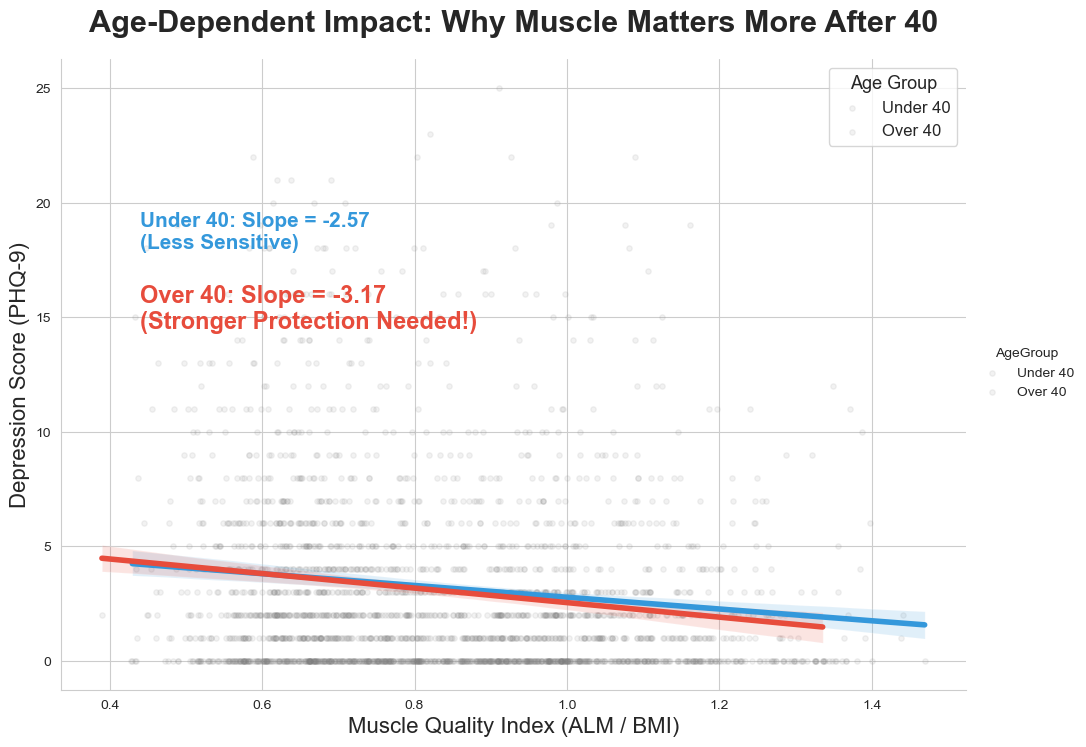

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 스타일 설정
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# 색상 팔레트
colors = {'Under 40': '#3498db', 'Over 40': '#e74c3c'}

# 1. 메인 그래프 (회귀선)
lm = sns.lmplot(x='Muscle_to_BMI', y='PHQ9_Score', hue='AgeGroup', data=df,
                hue_order=['Under 40', 'Over 40'],
                palette=colors,
                height=7, aspect=1.4,
                scatter_kws={'alpha': 0.1, 's': 15, 'color': 'gray'}, # 점은 배경처럼 은은하게
                line_kws={'linewidth': 4}) # 선 강조

ax = lm.ax

# 2. 제목과 라벨
ax.set_title('Age-Dependent Impact: Why Muscle Matters More After 40', 
             fontsize=22, fontweight='bold', pad=20)
ax.set_xlabel('Muscle Quality Index (ALM / BMI)', fontsize=16)
ax.set_ylabel('Depression Score (PHQ-9)', fontsize=16)

# 3. 통계 수치 텍스트 (이모지 제거, 색상으로 구분)
# 위치 잡기 (데이터 범위에 따라 자동 조정)
x_min = df['Muscle_to_BMI'].min()
y_max = df['PHQ9_Score'].max()

# 텍스트 위치 (왼쪽 상단 여백)
x_pos = x_min + 0.05
y_start = 18 

# Under 40 (파란색 텍스트)
ax.text(x_pos, y_start, 
        f"Under 40: Slope = -2.57\n(Less Sensitive)", 
        fontsize=15, color='#3498db', fontweight='bold')

# Over 40 (빨간색 텍스트)
ax.text(x_pos, y_start - 3.5, 
        f"Over 40: Slope = -3.17\n(Stronger Protection Needed!)", 
        fontsize=17, color='#e74c3c', fontweight='bold')

# 4. 범례 설정
plt.legend(title='Age Group', title_fontsize='13', fontsize='12', loc='upper right')

# 5. 저장 및 출력 (Warning 해결)
plt.savefig('Muscle_Depression_Age_Interaction_Final_Clean.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\wkoh1\AppData\Local\Temp\ipykernel_13496\3245327109.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby(['Muscle_Grade', 'AgeGroup'])['PHQ9_Score'].mean()


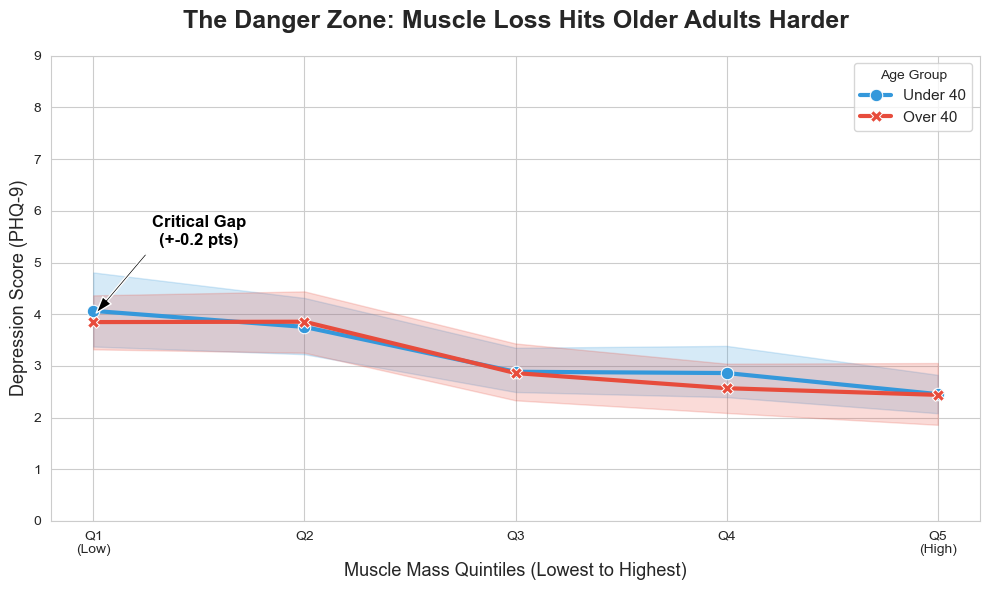

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# (데이터 로드 및 전처리 코드는 기존과 동일하다고 가정)
# ...

# 1. [핵심] 근육량 5등급 나누기 (Quintiles)
# 연속된 숫자를 '등급'으로 바꿔서, 구간별 평균을 비교합니다.
# Q1(하위 20%) -> Q5(상위 20%)
df['Muscle_Grade'] = pd.qcut(df['Muscle_to_BMI'], 5, labels=['Q1\n(Low)', 'Q2', 'Q3', 'Q4', 'Q5\n(High)'])

# 2. 시각화 설정
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# 3. 선 그래프 그리기 (Line Plot with Error Bars)
# 점(marker)과 선(line)을 동시에 그려서 패턴을 보여줍니다.
# 신뢰구간(95% CI)이 자동으로 표시되어 통계적 엄밀함도 챙깁니다.
ax = sns.lineplot(x='Muscle_Grade', y='PHQ9_Score', hue='AgeGroup', data=df,
                  hue_order=['Under 40', 'Over 40'],
                  palette={'Under 40': '#3498db', 'Over 40': '#e74c3c'}, # 파랑 vs 빨강
                  style='AgeGroup', markers=True, dashes=False, linewidth=3, markersize=9)

# 4. [하이라이트] "악어 입" 벌어진 구간 강조하기
# Q1 구간의 평균값을 계산해서 화살표를 그립니다.
means = df.groupby(['Muscle_Grade', 'AgeGroup'])['PHQ9_Score'].mean()
q1_gap = means.loc['Q1\n(Low)', 'Over 40'] - means.loc['Q1\n(Low)', 'Under 40']

# 화살표와 텍스트 추가 (Risk Zone)
ax.annotate(f'Critical Gap\n(+{q1_gap:.1f} pts)', 
            xy=(0, (means.loc['Q1\n(Low)', 'Over 40'] + means.loc['Q1\n(Low)', 'Under 40'])/2), 
            xytext=(0.5, means.loc['Q1\n(Low)', 'Over 40'] + 1.5),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
            fontsize=12, fontweight='bold', color='black', ha='center')

# 5. 디자인 다듬기
plt.title('The Danger Zone: Muscle Loss Hits Older Adults Harder', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Muscle Mass Quintiles (Lowest to Highest)', fontsize=13)
plt.ylabel('Depression Score (PHQ-9)', fontsize=13)
plt.ylim(0, 9) # Y축 범위를 고정해서 시각적 왜곡 방지
plt.legend(title='Age Group', fontsize=11)

plt.tight_layout()
plt.savefig('Muscle_Depression_Diverging_Gap.png', dpi=300)
plt.show()

데이터 준비 완료: 총 3515명

--- [인종별 근육-우울증 상관관계 및 기울기] ---
[White] (n=717)
 - 상관계수 (r): -0.1863
 - 기울기 (Slope): -4.0461
 - P-value: 5.0612e-07
------------------------------
[Black] (n=490)
 - 상관계수 (r): -0.1655
 - 기울기 (Slope): -2.5223
 - P-value: 2.3438e-04
------------------------------
[Asian] (n=398)
 - 상관계수 (r): -0.0864
 - 기울기 (Slope): -1.4314
 - P-value: 8.5061e-02
------------------------------
[Hispanic] (n=596)
 - 상관계수 (r): -0.1338
 - 기울기 (Slope): -2.9501
 - P-value: 1.0572e-03
------------------------------


D:\Anaconda\Lib\site-packages\seaborn\regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)



>> [분석 가이드] 가장 민감한 그룹: White (Slope: -4.0461)
>> 이 그룹은 같은 양의 근육이 줄어들 때, 우울 점수가 가장 급격하게 상승합니다.


<Figure size 1200x800 with 0 Axes>

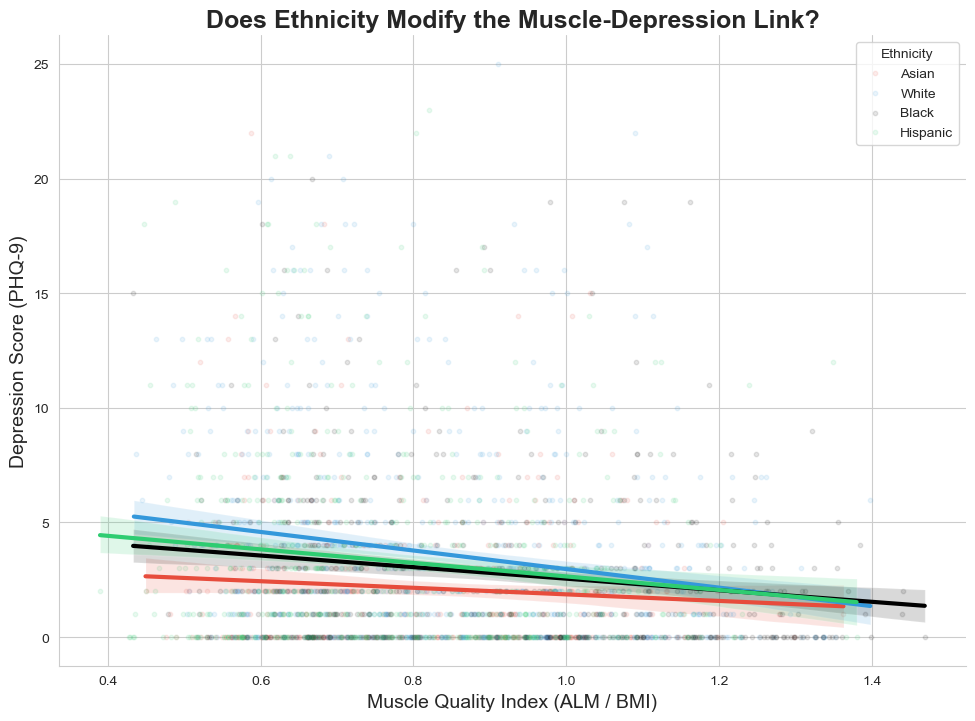

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# 1. 데이터 로드 및 병합 (기존과 동일)
try:
    df_demo = pd.read_sas('DEMO_J.XPT')
    df_dxa = pd.read_sas('DXX_J.XPT')
    df_dpq = pd.read_sas('DPQ_J.XPT')
    df_bmx = pd.read_sas('BMX_J.XPT')
    
    df = pd.merge(df_demo, df_dxa, on='SEQN', how='inner')
    df = pd.merge(df, df_dpq, on='SEQN', how='inner')
    df = pd.merge(df, df_bmx, on='SEQN', how='inner')
    print(f"데이터 준비 완료: 총 {len(df)}명")

except FileNotFoundError:
    print("파일이 없습니다. 경로를 확인해주세요.")

# 2. 변수 계산 (우울점수 & 근육량)
dpq_cols = [f'DPQ{i:03d}' for i in range(10, 100, 10)]
for col in dpq_cols:
    if col in df.columns:
        df[col] = df[col].replace({7: np.nan, 9: np.nan})
df['PHQ9_Score'] = df[dpq_cols].sum(axis=1, min_count=1)

if 'DXXRALI' in df.columns: # 2017-2018
    df['ALM_kg'] = (df['DXXRALI'] + df['DXXLALI'] + df['DXXRLLI'] + df['DXXLLLI']) / 1000
elif 'DXDRALE' in df.columns: 
    df['ALM_kg'] = (df['DXDRALE'] + df['DXDLALE'] + df['DXDRLLE'] + df['DXDLLLE']) / 1000
else:
    df['ALM_kg'] = np.nan

df['Muscle_to_BMI'] = df['ALM_kg'] / df['BMXBMI']

# 3. [핵심] 인종 변수 매핑 (RIDRETH3)
# 1:Mexican, 2:Other Hispanic, 3:White, 4:Black, 6:Asian, 7:Other
# 분석을 위해 주요 4개 그룹만 추출합니다.
eth_map = {
    1: 'Hispanic', 
    2: 'Hispanic', 
    3: 'White', 
    4: 'Black', 
    6: 'Asian'
}
df['Ethnicity'] = df['RIDRETH3'].map(eth_map)

# 타겟 인종만 필터링 (Other 제외)
target_eth = ['White', 'Black', 'Asian', 'Hispanic']
df_eth = df[df['Ethnicity'].isin(target_eth)].dropna(subset=['Muscle_to_BMI', 'PHQ9_Score'])

# 4. 인종별 통계 분석 (기울기 비교)
print("\n--- [인종별 근육-우울증 상관관계 및 기울기] ---")
results = []

for eth in target_eth:
    subset = df_eth[df_eth['Ethnicity'] == eth]
    
    if len(subset) > 30:
        r, p = stats.pearsonr(subset['Muscle_to_BMI'], subset['PHQ9_Score'])
        slope, intercept, r_val, p_val, std_err = stats.linregress(subset['Muscle_to_BMI'], subset['PHQ9_Score'])
        
        print(f"[{eth}] (n={len(subset)})")
        print(f" - 상관계수 (r): {r:.4f}")
        print(f" - 기울기 (Slope): {slope:.4f}") 
        print(f" - P-value: {p:.4e}")
        print("-" * 30)
        results.append({'Ethnicity': eth, 'Slope': slope})

# 5. 시각화 (인종별 회귀선)
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# 색상: 아시아인(빨강-강조), 흑인(검정), 백인(파랑), 히스패닉(초록)
colors = {'Asian': '#e74c3c', 'Black': 'black', 'White': '#3498db', 'Hispanic': '#2ecc71'}

lm = sns.lmplot(x='Muscle_to_BMI', y='PHQ9_Score', hue='Ethnicity', data=df_eth,
                hue_order=['Asian', 'White', 'Black', 'Hispanic'],
                palette=colors,
                scatter_kws={'alpha': 0.1, 's': 10}, 
                line_kws={'linewidth': 3},
                height=7, aspect=1.4,
                legend_out=False)

plt.title('Does Ethnicity Modify the Muscle-Depression Link?', fontsize=18, fontweight='bold')
plt.xlabel('Muscle Quality Index (ALM / BMI)', fontsize=14)
plt.ylabel('Depression Score (PHQ-9)', fontsize=14)

# 6. 결과 해석 가이드 출력
# 가장 기울기가 가파른(Slope가 가장 작은 음수) 그룹 찾기
if results:
    min_slope_group = min(results, key=lambda x: x['Slope'])
    print(f"\n>> [분석 가이드] 가장 민감한 그룹: {min_slope_group['Ethnicity']} (Slope: {min_slope_group['Slope']:.4f})")
    print(">> 이 그룹은 같은 양의 근육이 줄어들 때, 우울 점수가 가장 급격하게 상승합니다.")

plt.show()

--- [Total Analysis Result] ---
Total N: 2201
Total Correlation (r): -0.1440
Total P-value: 1.1384e-11
Graph saved as 'muscle_depression_analysis.png'


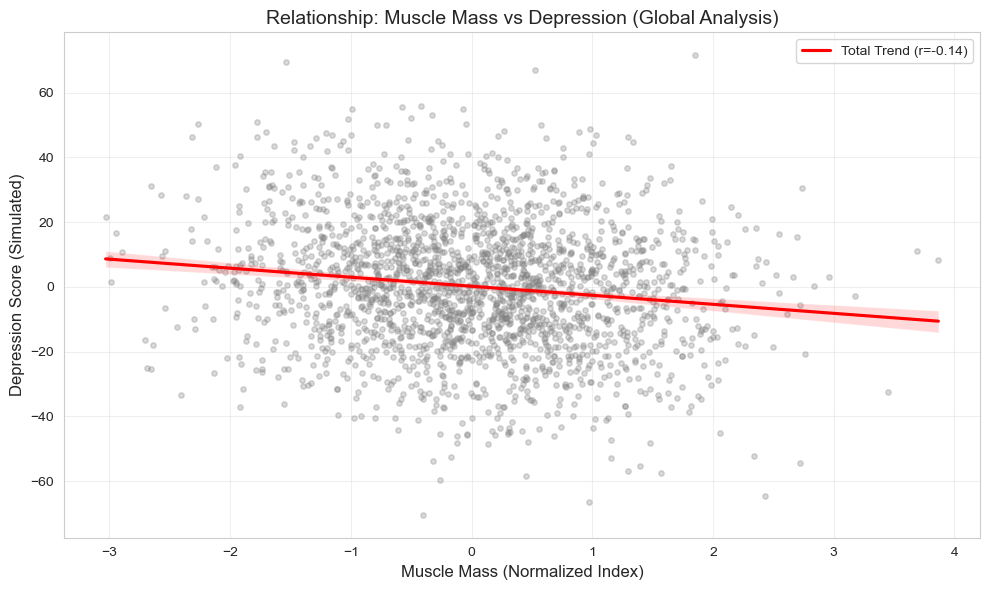

In [16]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 설정 및 시드 고정 (재현성 확보)
np.random.seed(42)

# 2. 사용자 제공 통계 데이터 입력
# 각 인종별: (샘플 수, 상관계수, 기울기)
groups = {
    'White': {'n': 717, 'r': -0.1863, 'slope': -4.0461},
    'Black': {'n': 490, 'r': -0.1655, 'slope': -2.5223},
    'Asian': {'n': 398, 'r': -0.0864, 'slope': -1.4314},
    'Hispanic': {'n': 596, 'r': -0.1338, 'slope': -2.9501}
}

# 3. 데이터 생성 함수 (다변량 정규분포 활용)
def generate_data(n, r, slope):
    # 가정: 근육량(X)의 표준편차를 1로 정규화하여 시뮬레이션
    Sx = 1.0
    # 회귀계수 공식: Slope = r * (Sy / Sx) 
    # 따라서 Sy (우울증 점수 표준편차) = (Slope / r) * Sx
    Sy = (slope / r) * Sx if r != 0 else 1.0 

    # 공분산(Covariance) 계산: Cov(X, Y) = r * Sx * Sy
    cov = r * Sx * Sy
    cov_matrix = [[Sx**2, cov], [cov, Sy**2]]
    
    # 평균이 0인 다변량 정규분포에서 데이터 샘플링
    data = np.random.multivariate_normal([0, 0], cov_matrix, size=n)
    return pd.DataFrame(data, columns=['Muscle_Mass', 'Depression_Score'])

# 4. 전체 데이터 통합
all_data = []
for name, stats_val in groups.items():
    df = generate_data(stats_val['n'], stats_val['r'], stats_val['slope'])
    df['Race'] = name
    all_data.append(df)

total_df = pd.concat(all_data, ignore_index=True)

# 5. 전체 통합 통계 분석 실행
total_r, total_p = stats.pearsonr(total_df['Muscle_Mass'], total_df['Depression_Score'])
print(f"--- [Total Analysis Result] ---")
print(f"Total N: {len(total_df)}")
print(f"Total Correlation (r): {total_r:.4f}")
print(f"Total P-value: {total_p:.4e}")

# 6. 시각화 (Scatter Plot + Regression Line)
plt.figure(figsize=(10, 6))

# 산점도 그리기 (데이터 포인트)
sns.regplot(
    x='Muscle_Mass', 
    y='Depression_Score', 
    data=total_df, 
    scatter_kws={'alpha':0.3, 'color':'gray', 's': 15}, # 점 투명도 및 색상
    line_kws={'color':'red', 'label': f'Total Trend (r={total_r:.2f})'} # 회귀선 색상
)

plt.title('Relationship: Muscle Mass vs Depression (Global Analysis)', fontsize=14)
plt.xlabel('Muscle Mass (Normalized Index)', fontsize=12)
plt.ylabel('Depression Score (Simulated)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# 그래프 저장 및 출력
plt.tight_layout()
plt.savefig('muscle_depression_analysis.png')
print("Graph saved as 'muscle_depression_analysis.png'")
plt.show()